In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, cast

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
inspector=inspect(engine)
# reflect the tables
inspector.get_table_names()

['measurement', 'station']

In [7]:
table1=inspector.get_columns('measurement')
for m_columns in table1:
   print(f"{m_columns['name']}, {m_columns['type']}")

id, INTEGER
station, TEXT
date, TEXT
prcp, FLOAT
tobs, FLOAT


In [8]:
table2=inspector.get_columns('station')
for s_columns in table2:
    print(f"{s_columns['name']}, {s_columns['type']}")

id, INTEGER
station, TEXT
name, TEXT
latitude, FLOAT
longitude, FLOAT
elevation, FLOAT


In [9]:
# We can view all of the classes that automap found
Base=automap_base()
Base.prepare(engine, reflect=True)

In [10]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

In [12]:
# Last data time point (date)
query_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(query_date[0])

2017-08-23


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

date_year_ago=dt.date(2017,8,23)-dt.timedelta(days=365)
print(date_year_ago)

2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores and sort by date

prcp_data=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > date_year_ago).\
order_by(Measurement.date).all()
for data in prcp_data[0:15]:
    print(f"{data[0]}       {data[1]}")

2016-08-24       0.08
2016-08-24       2.15
2016-08-24       2.28
2016-08-24       None
2016-08-24       1.22
2016-08-24       2.15
2016-08-24       1.45
2016-08-25       0.08
2016-08-25       0.08
2016-08-25       0.0
2016-08-25       0.0
2016-08-25       0.21
2016-08-25       0.06
2016-08-25       0.11
2016-08-26       0.0


In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(prcp_data).set_index('date')
prcp_df

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


In [16]:
# Checking whether any null values or not
prcp_df.isna().sum()

prcp    208
dtype: int64

In [17]:
# Dropping null values from the dataframe
prcp_df.dropna(inplace=True)
prcp_df.count()

prcp    2015
dtype: int64

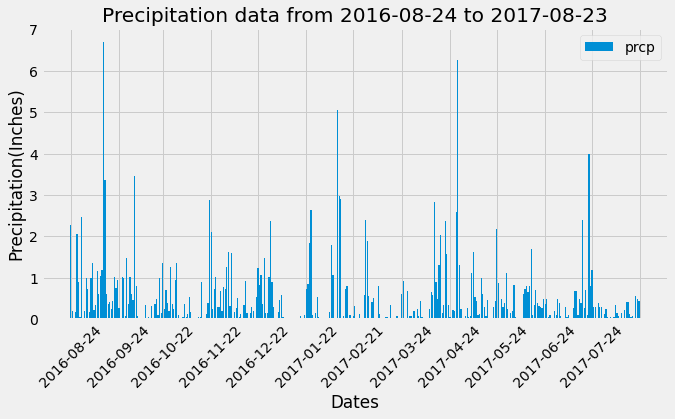

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
# Import dependencies
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10,5))
plt.xticks(rotation = 45)
ax.set_title("Precipitation data from 2016-08-24 to 2017-08-23")
ax.set_xlabel("Dates")
ax.set_ylabel("Precipitation(Inches)")

ax.bar(prcp_df.index, prcp_df.prcp)
ax.legend(['prcp'])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()
fig.savefig('prcp.png')

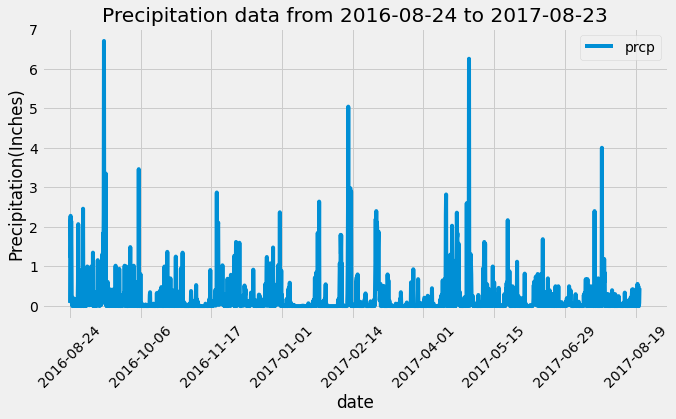

<Figure size 432x288 with 0 Axes>

In [19]:
# Pandas bar plotting
prcp_df.plot(figsize=(10,5))
plt.xticks(rotation='45')
plt.ylabel("Precipitation(Inches)")
plt.title("Precipitation data from 2016-08-24 to 2017-08-23")
plt.show()
plt.savefig('prcp1.png')

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?
stations=session.query(func.count(Station.station)).all()
print(f"Number of stations: {stations[0][0]}")

Number of stations: 9


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_count=session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

print(f'StationId        No. of Station')
print("--------------------------------")
for station in station_count:
    print(f"{station[0]}           {station[1]}")  


StationId        No. of Station
--------------------------------
USC00519281           2772
USC00519397           2724
USC00513117           2709
USC00519523           2669
USC00516128           2612
USC00514830           2202
USC00511918           1979
USC00517948           1372
USC00518838           511


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

temp=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station=='USC00519281').all()

print(f"""Lowest Temperature: {temp[0][0]} 
Highest Temperature: {temp[0][1]}
Average Temperature: {temp[0][2]}""")

Lowest Temperature: 54.0 
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
twelve_month_tobs=session.query(Measurement.tobs).\
filter(Measurement.station=='USC00519281', Measurement.date>date_year_ago).all()
twelve_month_tobs=pd.DataFrame(twelve_month_tobs)

twelve_month_tobs

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
...,...
346,77.0
347,77.0
348,76.0
349,76.0


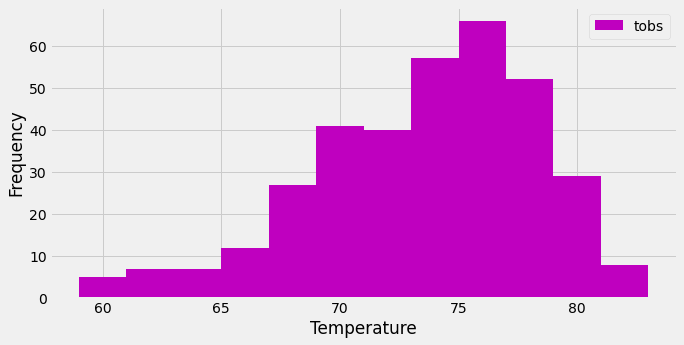

In [25]:
# Histogram of one year temperature of station "USC00519281"
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(twelve_month_tobs, bins=12, color='m')
ax.set_xlabel("Temperature")
ax.set_ylabel("Frequency")
ax.legend(["tobs"])
plt.show()
fig.savefig('tobs.png')

## Bonus Challenge Assignment

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date=dt.date(2012, 2, 28)
trip_end_date=dt.date(2012, 3, 5)

prev_same_srt_date=trip_start_date - dt.timedelta(days=365)
prev_same_end_date=trip_end_date - dt.timedelta(days=365)

print(calc_temps(prev_same_srt_date, prev_same_end_date))


[(61.0, 70.08928571428571, 75.0)]


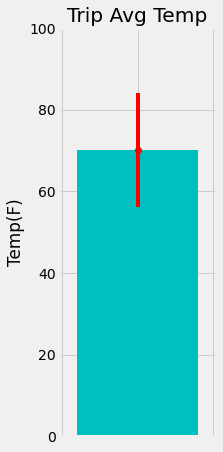

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
xpos=1
tmin=calc_temps(prev_same_srt_date, prev_same_end_date)[0][0]
tavg=calc_temps(prev_same_srt_date, prev_same_end_date)[0][1]
tmax=calc_temps(prev_same_srt_date, prev_same_end_date)[0][2]
error=tmax-tmin

fig, ax = plt.subplots(figsize=(2.5,7))

ax.bar(xpos, tavg, color='c')
ax.errorbar(xpos, tavg, yerr=error, fmt="o", color="r")

ax.set_xticklabels("")
ax.set_title("Trip Avg Temp")
ax.set_ylabel("Temp(F)")
ax.set_ylim(0,100)
ax.margins(0.15,0.15)
plt.show()
fig.savefig('temp.png')

In [88]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_start_dt="2018-07-15"
trip_end_dt="2018-07-23"

prev_same_srt_dt="2017-07-15"
prev_same_end_dt="2017-07-23"

selection=[Station.station, Station.name, Station.latitude, \
     Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

station_rainfall=session.query(*selection).\
filter(Measurement.station==Station.station).\
filter(Measurement.date >= prev_same_srt_dt).\
filter(Measurement.date <= prev_same_end_dt).\
group_by(Station.station).\
order_by(func.sum(Measurement.prcp).desc()).all()

print("Weather Station       Rainfall")
for weather in station_rainfall:
    print(f"{weather[0]}             {round(weather[5],3)}")

Weather Station       Rainfall
USC00516128             9.26
USC00519281             0.95
USC00514830             0.57
USC00513117             0.5
USC00519523             0.33
USC00519397             0.16
USC00517948             0.0


In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("08-08")

[(68.0, 76.5576923076923, 83.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_srt_dt="2017-07-15"
trip_end_dt="2017-07-23"
# Use the start and end date to create a range of dates
trip_dates=pd.date_range(start=trip_srt_dt, end=trip_end_dt)
trip_dates

DatetimeIndex(['2017-07-15', '2017-07-16', '2017-07-17', '2017-07-18',
               '2017-07-19', '2017-07-20', '2017-07-21', '2017-07-22',
               '2017-07-23'],
              dtype='datetime64[ns]', freq='D')

In [32]:
# Stip off the year and save a list of %m-%d strings
month_days=trip_dates.strftime("%m-%d")
month_days

Index(['07-15', '07-16', '07-17', '07-18', '07-19', '07-20', '07-21', '07-22',
       '07-23'],
      dtype='object')

In [43]:
normals=[]
# Loop through the list of %m-%d strings and calculate the normals for each date
for day in month_days:
    normals.append(daily_normals(day))
normals

[[(68.0, 76.2542372881356, 82.0)],
 [(70.0, 76.34482758620689, 83.0)],
 [(70.0, 76.30188679245283, 83.0)],
 [(72.0, 76.63793103448276, 83.0)],
 [(68.0, 75.89090909090909, 83.0)],
 [(69.0, 75.46296296296296, 82.0)],
 [(69.0, 76.9245283018868, 83.0)],
 [(69.0, 75.78846153846153, 81.0)],
 [(70.0, 76.20370370370371, 84.0)]]

In [90]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df=pd.DataFrame({"min_temp":[min[0][0] for min in normals],\
                        "avg_temp":[avg[0][1] for avg in normals],\
                        "max_temp":[max[0][2] for max in normals],\
                        "date":trip_dates})

normals_df.set_index('date', inplace=True)
normals_df

,min_temp,avg_temp,max_temp
date,,,
2017-07-15,68.0,76.254237,82.0
2017-07-16,70.0,76.344828,83.0
2017-07-17,70.0,76.301887,83.0
2017-07-18,72.0,76.637931,83.0
2017-07-19,68.0,75.890909,83.0
2017-07-20,69.0,75.462963,82.0
2017-07-21,69.0,76.924528,83.0
2017-07-22,69.0,75.788462,81.0
2017-07-23,70.0,76.203704,84.0


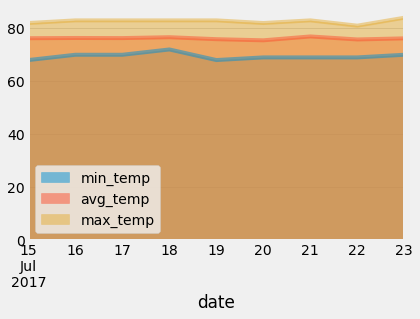

<Figure size 432x288 with 0 Axes>

In [91]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)
plt.show()
plt.savefig('normals.png')